In [1]:
import torch
import torch.nn as nn
from torch import optim
from torch.autograd import Variable
import torch.nn.functional as F

import numpy as np
import glob
from tqdm import tqdm
import matplotlib.pyplot as plt
import umap.umap_ as umap
from sklearn.metrics import confusion_matrix

import sys
sys.path.append('../')

import random
seed = 777
random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
np.random.seed(seed)

import os
os.environ["PYTHONHASHSEED"]=str(seed)
torch.backends.cudnn.deterministic = True  # type: ignore
torch.backends.cudnn.benchmark = True  # type: ignore

import loader.load_from_h5 as loadh5
from model.model_binary import MyModel

In [2]:
data_file = glob.glob('../data/*.h5')
train_loader = loadh5.FeatureDataset(data_file).get_dataloader(split_type='training')
val_loader = loadh5.FeatureDataset(data_file).get_dataloader(split_type='validation')
test_loader = loadh5.FeatureDataset(data_file).get_dataloader(split_type='test')

model = MyModel().to('cuda')

c_criterion = nn.NLLLoss()
t_criterion = nn.TripletMarginLoss()
optimizer = optim.Adam(model.parameters(),lr=1e-3)

target_la = 0

epochs = 20

In [3]:
model.load_state_dict(torch.load('../result/model_0_Vs_All_best.pth'))

<All keys matched successfully>

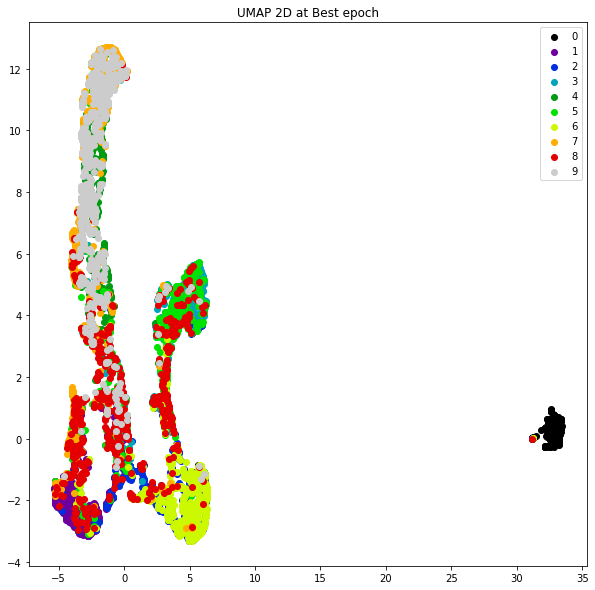

In [4]:
model.eval()
tst_embedded = []
tst_y = []
with torch.no_grad():
    for x, y in test_loader:
        x = Variable(x.float()).to('cuda')
        embedded = model.embedding(x.view(-1,784)).detach().cpu()
        tst_embedded.append(embedded)
        tst_y.append(y)
            
tst_embedded = torch.cat(tst_embedded)
tst_y = torch.cat(tst_y)
#print(tst_embedded.shape,tst_y.shape)
hle = umap.UMAP(random_state=0,metric='euclidean',n_components=2,n_neighbors=20,min_dist=0).fit_transform(tst_embedded)
c_lst = [plt.cm.nipy_spectral(a) for a in np.linspace(0.0, 1.0, len(np.unique(tst_y)))]
plt.figure(figsize=(10,10))
for i in range(0,len(np.unique(tst_y))):
    #print('Class ',i,'x :',hle[tst_y==i,0])
    #print('Class ',i,'y :',hle[tst_y==i,1])
    plt.scatter(hle[tst_y==i,0],hle[tst_y==i,1],label=i,color=c_lst[i])
plt.legend(loc='best')
plt.title('UMAP 2D at Best epoch')
plt.show()

In [5]:
label = []
pred = []
with torch.no_grad():
    for x, y in test_loader:
        #print(y)
        for y_idx, y_i in enumerate(y):
            #print(y.shape)
            if y_i == target_la:
                y[y_idx] = 0
            else:
                y[y_idx] = 1
        #print(y)
        x = Variable(x.float()).to('cuda')
        y = Variable(y.type(torch.LongTensor)).to('cuda')
        out = model(x)
                
        out_sm = F.softmax(out,dim=1).cpu()
        predict = (F.softmax(out_sm,dim=1)).argmax(1).cpu()
        label.append(y.cpu().numpy())
        pred.append(predict.cpu().numpy())
label = np.concatenate(label)
pred = np.concatenate(pred)
print(label.shape)
print(pred.shape)
confusion_mat = confusion_matrix(label,pred)
print(confusion_mat)

(7000,)
(7000,)
[[ 715    1]
 [   2 6282]]
